In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#the next is to to visualize plots inside jupyter!
%matplotlib inline 

from scipy import stats

from sklearn.preprocessing import StandardScaler

# Preprocessing: missing values, normalization, binning and Hot-Encoding

In [2]:
pd.set_option('future.no_silent_downcasting', True)

url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod1.csv"
df = pd.read_csv(url, header=0)
df.loc[27, 'CPU_core'] = np.nan #iserted this to handle missing values in the next stage
df.drop(['Unnamed: 0'],axis=1,inplace=True) #drops the column 'Unnamed: 0'
df['Price']=df['Price'].astype('float64') #convert the 'Price' column to float
print('In this database there are m =',df.shape[0],'data with D =',df.shape[1],'features.')
df.head(8)

In this database there are m = 238 data with D = 12 features.


,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_cm,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price
0,Acer,4,IPS Panel,2,1,5.0,35.560,1.6,8,256,1.60,978.0
1,Dell,3,Full HD,1,1,3.0,39.624,2.0,4,256,2.20,634.0
2,Dell,3,Full HD,1,1,7.0,39.624,2.7,8,256,2.20,946.0
3,Dell,4,IPS Panel,2,1,5.0,33.782,1.6,8,128,1.22,1244.0
4,HP,4,Full HD,2,1,7.0,39.624,1.8,8,256,1.91,837.0
5,Dell,3,Full HD,1,1,5.0,39.624,1.6,8,256,2.20,1016.0
6,HP,3,Full HD,3,1,5.0,39.624,1.6,8,256,2.10,1117.0
7,Acer,3,IPS Panel,2,1,5.0,38.100,1.6,4,256,2.20,866.0


## Missing values  

We want to detect missing values in the dataframe

In [ ]:
def NaN_value_finder(dataframe):
    dataframe=dataframe.replace('?',np.nan)
    missing_data = dataframe.isnull()
    missing_dict=dict()
    missing_index=list()
    for column in missing_data.columns.values.tolist():
        for i,value in enumerate(missing_data[column]):
            if missing_data[column][i]==True:
                missing_index.append(i)
                missing_dict[column]=missing_dict.get(column,0)+1
    for i,value in enumerate(missing_dict):
        print('There are', missing_dict[value], 'out of',dataframe.shape[0],
              'null values in the column',value,'(',np.round((missing_dict[value]/dataframe.shape[0])*100,2).item(),'%)')
    return missing_dict, missing_index


missing_dict, missing_index = NaN_value_finder(df)

There are 1 null values in the column CPU_core
There are 4 null values in the column Screen_Size_cm
There are 5 null values in the column Weight_kg


({'CPU_core': 1, 'Screen_Size_cm': 4, 'Weight_kg': 5},
 [27, 120, 151, 187, 230, 29, 38, 49, 61, 68])

We now replace the missing values:

- in columns 'Screen_Size_cm' and 'Weight_kg' with the mean of that column. Before doing this, it is important to convert the type of variables in that column into float;
- in 'CPU_core' with the most frequent entry of that column;

Then check the missing values again. 

In [297]:
df['Screen_Size_cm'] = df['Screen_Size_cm'].astype(float).replace(np.nan, df['Screen_Size_cm'].astype(float).mean())
df['Weight_kg'] = df['Weight_kg'].astype(float).replace(np.nan, df['Weight_kg'].astype(float).mean())

df['CPU_core']=df['CPU_core'].replace(np.nan,df['CPU_core'].value_counts().idxmax()).astype(int)

print(NaN_value_finder(df))

({}, [])


## Z-score normalization: centering and scaling

All the columns containing floats should be normalized

In [309]:
def Z_score_normalization(df, type):
    for i, value in enumerate(df.columns):
        if df[value].dtype.name == type:
            df[value] = (df[value] - df[value].mean()) / df[value].std()
            # df.rename(columns={value: 'Z-normalized ' + value}, inplace=True)
    
Z_score_normalization(df,'float64')

df

,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_cm,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_kg,Price
0,Acer,4,IPS Panel,2,1,5,-0.580281,-1.847588,8,256,-0.536163,-0.842913
1,Dell,3,Full HD,1,1,3,0.799130,-0.875281,4,256,0.690606,-1.441583
2,Dell,3,Full HD,1,1,7,0.799130,0.826257,8,256,0.690606,-0.898604
3,Dell,4,IPS Panel,2,1,5,-1.183774,-1.847588,8,128,-1.313117,-0.379989
4,HP,4,Full HD,2,1,7,0.799130,-1.361434,8,256,0.097668,-1.088298
...,...,...,...,...,...,...,...,...,...,...,...,...
233,Lenovo,4,IPS Panel,2,1,7,-0.580281,0.583180,8,256,-0.331702,0.745997
234,Toshiba,3,Full HD,2,1,5,-1.183774,0.097026,8,256,-1.354009,0.848675
235,Lenovo,4,IPS Panel,2,1,5,-2.304546,0.583180,8,256,-1.026871,1.346406
236,Lenovo,3,Full HD,3,1,5,0.799130,0.340103,6,256,1.099529,-1.008244


Another way to to Z-score normalization is by using 'from sklearn.preprocessing import StandardScaler' in the following way:

In [8]:
def Z_score_normalization(old_df, type):
    continuous_columns = old_df.select_dtypes(include=['float64']).columns.tolist() #list of the columns to be normalized
    scale=StandardScaler()
    scale.fit(old_df[continuous_columns])
    scaled_features=scale.transform(old_df[continuous_columns])
    scaled_df=pd.DataFrame(scaled_features, columns=continuous_columns)

    df=pd.concat([old_df.drop(columns=continuous_columns),scaled_df],axis=1)
    
    for i, value in enumerate(df.columns):
        if df[value].dtype.name == type:
            df.rename(columns={value: 'Z-normalized ' + value}, inplace=True)
    
    means_ = scale.mean_
    std_devs_ = np.sqrt(scale.var_)
    #coef_original = coef_ / std_devs_
    #intercept_original = intercept_ - np.sum((means_ * coef_) / std_devs_)

    return df
    
multiple=['Screen_Size_cm','CPU_frequency','Weight_kg','Price']
X=df[multiple] #sub-DF containing the float64

Z_score_normalization(df,'float64').head()

,Manufacturer,Category,Screen,GPU,OS,RAM_GB,Storage_GB_SSD,Z-normalized CPU_core,Z-normalized Screen_Size_cm,Z-normalized CPU_frequency,Z-normalized Weight_kg,Z-normalized Price
0,Acer,4,IPS Panel,2,1,8,256,-0.504184,-0.576597,-1.851482,-0.531619,-0.844690
1,Dell,3,Full HD,1,1,4,256,-2.118934,0.794056,-0.877125,0.684753,-1.444621
2,Dell,3,Full HD,1,1,8,256,1.110567,0.794056,0.827998,0.684753,-0.900497
3,Dell,4,IPS Panel,2,1,8,128,-0.504184,-1.176258,-1.851482,-1.301989,-0.380790
4,HP,4,Full HD,2,1,8,256,1.110567,0.794056,-1.364304,0.096840,-1.090592


Come back from the normalization:

In [5]:
# Get the standard scaler's mean and standard deviation parameters
means_ = scale.mean_
std_devs_ = np.sqrt(scale.var_)

# The least squares parameters can be calculated relative to the original, unstandardized feature space as:
#coef_original = coef_ / std_devs_
#intercept_original = intercept_ - np.sum((means_ * coef_) / std_devs_)

# print ('Coefficients: ', coef_original)
# print ('Intercept: ', intercept_original)

NameError: name 'scale' is not defined

## One hot-encoding

Notice that the column 'Manufacturer' is categorical. It is possible that I would like to predict to which class of 'Manufacturer' a specific computer belongs to. To this end, I will use a softmax, and it is inecessary to do one-hot encoding on the 'Manufacturer' category.

In [252]:
df['Manufacturer'].value_counts().shape # (11,), so there are 11 catgories, and I will create a 11-dimensional vector with ones and zeros
df=pd.concat([df,pd.get_dummies(df['Manufacturer'])],axis=1) #add 11 columns
#df.drop(['Manufacturer'],axis=1,inplace=True) #drop the 'Manufacturer' column

## Binning

Maybe we want to predict the price, but maybe we only want the output of our net to be a category: 'Low','Medium' or 'High'. After, this can be also converted to one hot encoding.

In [253]:
num_of_bins=3 #number of categories I would like to distinguish
bins=np.linspace(df['Price'].min(),df['Price'].max(),num_of_bins+1) #this creates three intervals, equally divided between the max and min of the price
name_of_bins=['Low','Medium','High']

df['Price-binned']=pd.cut(df['Price'],bins,labels=name_of_bins,include_lowest=True)
df


,Manufacturer,Category,Screen,GPU,OS,CPU_core,Screen_Size_cm,CPU_frequency,RAM_GB,Storage_GB_SSD,...,Dell,HP,Huawei,Lenovo,MSI,Razer,Samsung,Toshiba,Xiaomi,Price-binned
0,Acer,4,IPS Panel,2,1,5,-0.580281,-1.847588,8,256,...,False,False,False,False,False,False,False,False,False,Low
1,Dell,3,Full HD,1,1,3,0.799130,-0.875281,4,256,...,True,False,False,False,False,False,False,False,False,Low
2,Dell,3,Full HD,1,1,7,0.799130,0.826257,8,256,...,True,False,False,False,False,False,False,False,False,Low
3,Dell,4,IPS Panel,2,1,5,-1.183774,-1.847588,8,128,...,True,False,False,False,False,False,False,False,False,Low
4,HP,4,Full HD,2,1,7,0.799130,-1.361434,8,256,...,False,True,False,False,False,False,False,False,False,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,Lenovo,4,IPS Panel,2,1,7,-0.580281,0.583180,8,256,...,False,False,False,True,False,False,False,False,False,Medium
234,Toshiba,3,Full HD,2,1,5,-1.183774,0.097026,8,256,...,False,False,False,False,False,False,False,True,False,Medium
235,Lenovo,4,IPS Panel,2,1,5,-2.304546,0.583180,8,256,...,False,False,False,True,False,False,False,False,False,Medium
236,Lenovo,3,Full HD,3,1,5,0.799130,0.340103,6,256,...,False,False,False,True,False,False,False,False,False,Low


# Correlation and Statistic

## Integers and floats

First we have to give a look to the types of each column, and among the integers and float we can study the correlation matrix (or the heat map, which is the same).

Category            int64
Screen             object
GPU                 int64
OS                  int64
CPU_core            int64
Screen_Size_cm    float64
CPU_frequency     float64
RAM_GB              int64
Storage_GB_SSD      int64
Weight_kg         float64
Price             float64
dtype: object
                Category       GPU        OS  CPU_core  Screen_Size_cm  \
Category        1.000000 -0.114174 -0.043378  0.234708       -0.305035   
GPU            -0.114174  1.000000 -0.199549  0.157969        0.152979   
OS             -0.043378 -0.199549  1.000000  0.018687        0.150835   
CPU_core        0.234708  0.157969  0.018687  1.000000        0.031928   
Screen_Size_cm -0.305035  0.152979  0.150835  0.031928        1.000000   
CPU_frequency  -0.053414  0.291439  0.050407  0.237594       -0.002262   
RAM_GB          0.030127  0.218973 -0.074625  0.473724        0.017651   
Storage_GB_SSD  0.038246  0.094288  0.007751  0.398834        0.116368   
Weight_kg      -0.381032  0.262853

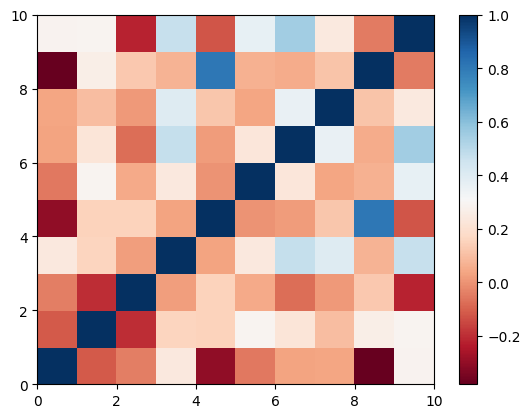

Category         -0.305035
Price            -0.126672
CPU_frequency    -0.002262
RAM_GB            0.017651
CPU_core          0.031928
Storage_GB_SSD    0.116368
OS                0.150835
GPU               0.152979
Weight_kg         0.810703
Screen_Size_cm    1.000000
Name: Screen_Size_cm, dtype: float64 




In [230]:
print(df.dtypes.head(11))

print((df.select_dtypes(include=['int64','float64']).corr()),'\n\n') #the .corr() method from pd does the pearson automatically

x=(df.select_dtypes(include=['int64','float64']).corr())
plt.pcolor(x,cmap='RdBu')
plt.colorbar()
plt.show()
plt.close()

print((df.select_dtypes(include=['int64','float64']).corr())['Screen_Size_cm'].sort_values(),'\n\n')

There seems to be a strong positive (Pearson-->linear!) correlation between 'Weight_kg' and 'Screen_Size_cm'. Instead the correlation is low for 'RAM_GB' and 'Screen_Size_cm', and there is a weak negative correlation with 'Category'. This can be checked also visually:

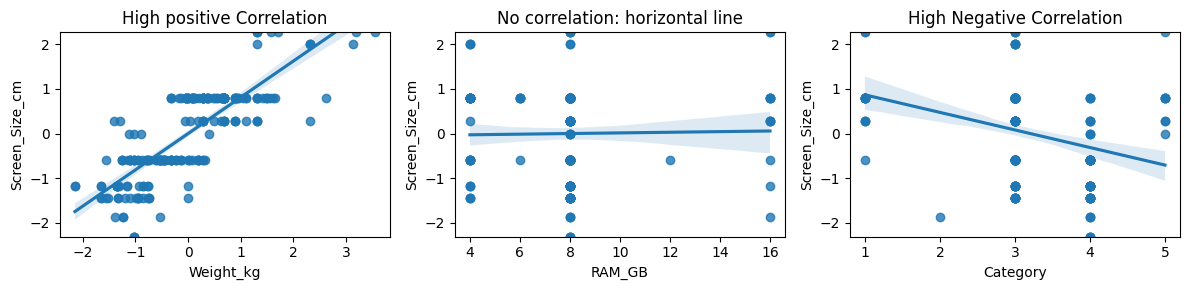

In [238]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

min=df['Screen_Size_cm'].min()
max=df['Screen_Size_cm'].max()

# 1° plot
sns.regplot(x='Weight_kg', y='Screen_Size_cm', data=df, ax=axes[0])
axes[0].set_xlabel('Weight_kg')
axes[0].set_ylabel('Screen_Size_cm')
axes[0].set_ylim(min, max)
axes[0].set_title('High positive Correlation')

# 2° plot
sns.regplot(x='RAM_GB', y='Screen_Size_cm', data=df, ax=axes[1])
axes[1].set_xlabel('RAM_GB')
axes[1].set_ylabel('Screen_Size_cm')
axes[1].set_ylim(min, max)
axes[1].set_title('No correlation: horizontal line')

# 3° plot
sns.regplot(x='Category', y='Screen_Size_cm', data=df, ax=axes[2])
axes[2].set_xlabel('Category')
axes[2].set_ylabel('Screen_Size_cm')
axes[2].set_ylim(min, max)
axes[2].set_title('High Negative Correlation')

plt.tight_layout()
plt.show()
plt.close()

Finally we can study better the Pearson and the p-value, whic expresses correlation for p<0.001

In [264]:
def p_value_function(colname):
    i=0
    x=(df.select_dtypes(include=['int64','float64']).corr())[colname].sort_values().to_frame().reset_index()['index']
    while i<len(x):
        y=x[i]
        pearson_coef, p_value =stats.pearsonr(df[y],df[colname]) #function: from scipy import stats
        i=i+1
        if  p_value<0.001 and p_value>0:
            print('The Pearson Correlation Coefficient of', y ,'and', colname ,'is', pearson_coef, " with a P-value of P =", p_value) 

p_value_function('Screen_Size_cm')

The Pearson Correlation Coefficient of Category and Screen_Size_cm is -0.3050347631335606  with a P-value of P = 1.619788020134307e-06
The Pearson Correlation Coefficient of Weight_kg and Screen_Size_cm is 0.8107032611693302  with a P-value of P = 8.591809114167626e-57


## Categorical variables

We have to look for example if the classes of 'Manufacturer' are well distributed, and they are not! Also, visually (using the boxplot) we see that this can not be a good predictor, beacuse many 'Manufacturer' has the same screen_Size_cm'.

Manufacturer
Dell       71
Lenovo     52
HP         49
Acer       19
Asus       18
Toshiba    17
Samsung     5
MSI         4
Huawei      1
Razer       1
Xiaomi      1
Name: count, dtype: int64


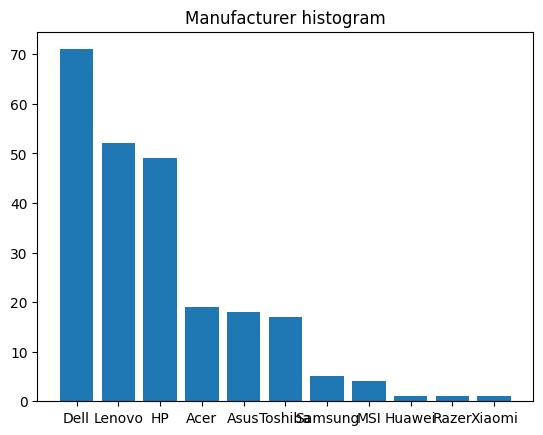

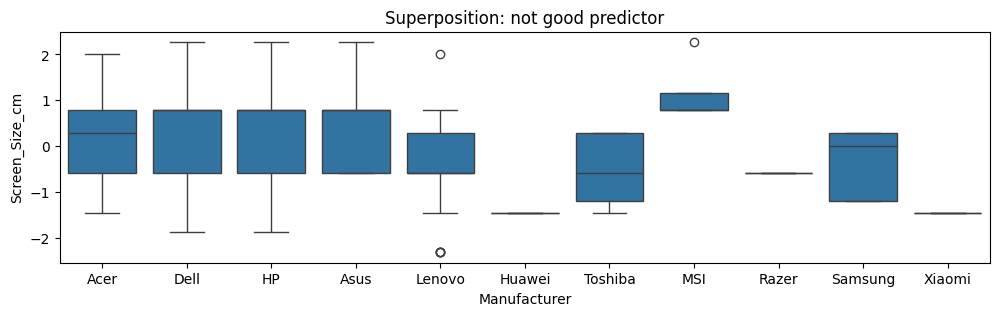

In [263]:
print(df['Manufacturer'].value_counts())


x=df['Manufacturer'].value_counts().to_frame().reset_index().rename(columns={'Manufacturer': 'value_counts'})
plt.bar(x.iloc[:,0],x.iloc[:,1])
plt.title('Manufacturer histogram')
plt.show()
plt.close()

fig, axes = plt.subplots(1, 1, figsize=(12, 3))  # 1 row, 3 columns
sns.boxplot(x='Manufacturer',y='Screen_Size_cm',data=df,ax=axes)
axes.set_title('Superposition: not good predictor')
plt.show()
plt.close()

   Manufacturer     Screen  Screen_Size_cm
0          Acer    Full HD        0.799130
1          Acer  IPS Panel        0.158689
2          Asus    Full HD        0.373452
3          Asus  IPS Panel       -0.149215
4          Dell    Full HD        0.216763
5          Dell  IPS Panel       -0.810183
6            HP    Full HD        0.412222
7            HP  IPS Panel       -0.580281
8        Huawei  IPS Panel       -1.442414
9        Lenovo    Full HD        0.118046
10       Lenovo  IPS Panel       -0.688048
11          MSI    Full HD        1.165536
12        Razer    Full HD       -0.580281
13      Samsung    Full HD       -0.360769
14      Toshiba    Full HD       -1.097561
15      Toshiba  IPS Panel       -0.235428
16       Xiaomi  IPS Panel       -1.442414 


             Screen_Size_cm          
Screen              Full HD IPS Panel
Manufacturer                         
Acer               0.799130  0.158689
Asus               0.373452 -0.149215
Dell               0.216763 -0.81

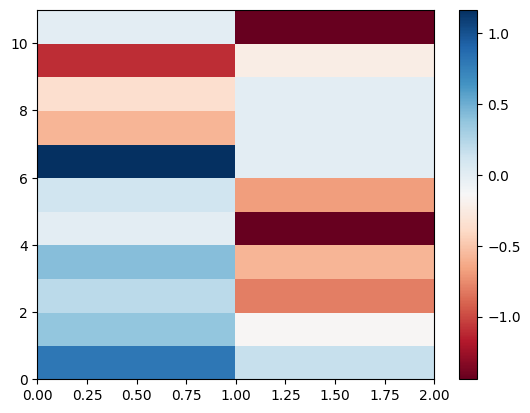

In [266]:
x=df[['Manufacturer','Screen','Screen_Size_cm']].groupby(['Manufacturer','Screen'],as_index=False).mean()
print(x,'\n\n')

print(x.pivot(index='Manufacturer', columns='Screen'),'\n\n')

y=x.pivot(index='Manufacturer', columns='Screen').fillna(0)

print(y) #fill the Nan with 0

plt.pcolor(y,cmap='RdBu')
plt.colorbar()
plt.show()

In [265]:
df.dtypes

Manufacturer        object
Category             int64
Screen              object
GPU                  int64
OS                   int64
CPU_core             int64
Screen_Size_cm     float64
CPU_frequency      float64
RAM_GB               int64
Storage_GB_SSD       int64
Weight_kg          float64
Price              float64
Acer                  bool
Asus                  bool
Dell                  bool
HP                    bool
Huawei                bool
Lenovo                bool
MSI                   bool
Razer                 bool
Samsung               bool
Toshiba               bool
Xiaomi                bool
Price-binned      category
dtype: object